Experiment for consistency result for the (do intervention) CFI consistency, larger number of repetition will be done in a script on server.

In [1]:
%load_ext autoreload
%autoreload 2

import sys
sys.path.insert(0, "../../")

In [2]:
import numpy as np
import pandas as pd
from sklearn import svm
from sklearn.kernel_ridge import KernelRidge
from sklearn.ensemble import RandomForestRegressor
from sklearn.dummy import DummyRegressor
import seaborn as sns

from IPython.display import clear_output
import timeit
from itertools import product

from src.kernels_jax import *
from src.metrics_jax import *
from src.utils import *
from src.cfi import *

/Users/hrt620/.pyenv/versions/3.9.9/envs/kb39/lib/python3.9/site-packages/jax/_src/lib/__init__.py:32: UserWarning: JAX on Mac ARM machines is experimental and minimally tested. Please see https://github.com/google/jax/issues/5501 in the event of problems.
  warnings.warn("JAX on Mac ARM machines is experimental and minimally tested. "


In [93]:
from matplotlib import rc
rc('font', **{'family':'tex-gyre-termes', 'size':6.5})
rc('text', usetex=True)
rc('text.latex', preamble=r'\usepackage{amsfonts,amssymb,amsthm,amsmath}')

### Local tries

Data generation functions

In [77]:
rng = np.random.default_rng(2022)

In [4]:
# Note: this ref_pt is a global variable
p = 9
ref_pt = rng.uniform(0,1,p)[None,:]
ref_pt /= ref_pt.sum()

def true_fun(X):
    n, p = X.shape
    alpha = 100
    return np.array(kmat_hilbert2(X,ref_pt,a=1,b=-np.inf).dot(alpha)).reshape(n,) # a funciton in the RKHS of tv kernel

In [5]:
def gen_data(n, true_fun):
    mu = [0,0,0]
    cov = [[1, 0.25, -0.25],
        [0.25, 1, 0.25],
        [-0.25, 0.25, 1]]
    X1 = rng.multivariate_normal(mu, cov, n) # 0, 1, 2
    X2 = rng.multivariate_normal(mu, cov, n) # 3, 4, 5
    X3 = rng.multivariate_normal(mu, cov, n) # 6, 7, 8
    X = np.concatenate([X1, X2, X3], axis=1)
    X = np.exp(X)
    X /= X.sum(axis=1)[:,None]
    y = true_fun(X) + rng.normal(0,1,n)
    return X, y

Calculate true CFI

In [6]:
n = 10**4
p = 9
n_grid = 100
cfi_vals_true = np.zeros((p,n_grid))
supp_grid = get_gen_grid(n_grid, p, 0, 1)
X, y = gen_data(n, true_fun)
cfi_vals_true = get_cfi(X, supp_grid, true_fun)

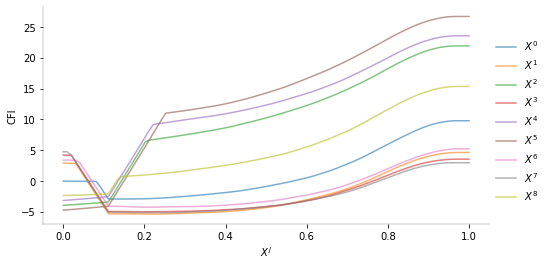

In [7]:
fig, axs = plt.subplots(1,1,figsize=(8,4))
plot_cfi(supp_grid, cfi_vals_true, labels=[f'$X^{jj}$' for jj in range(X.shape[1])], axs=axs)
handles, labels = axs.get_legend_handles_labels()
fig.legend(handles, labels, bbox_to_anchor=(1, 0.8), frameon=False)
plt.show()

#### Consistency of CFI under correct and incorrect model specifications

In [8]:
def run_consistency(ns, gen_data_fun, estimator_fun, n_repeat=10):
    """
    ns: List
        a list of number of samples.
    gen_data_fun: Callable
        a function that takes only the number of samples n and returns X, y
    estimator: Callable
        a function that takes X, y and returns a prediction function, the selected hyperparameters, kernel matrix function, and the name of the kernel
    """
    influence_mod = []
    for ii, n in enumerate(ns):
        # clear_output(wait=True)
        print(f'-- ii = {ii} (n = {n}) --')
        cfi_loc = np.zeros((n_repeat, p, n_grid))
        for jj in range(n_repeat):
            X, y = gen_data_fun(n)
            pred_fun, gscv_best_params, kmat_fun, kernel_name = estimator_fun(X,y)
            print(f"best hyperparams {gscv_best_params} with {kernel_name}")
            cfi_loc[jj] = get_cfi(X, supp_grid, pred_fun, kmat_fun, False)
        influence_mod.append(cfi_loc)
    # average MSE of the 9 curves at each sample size n
    mse = np.zeros((len(ns), n_repeat))
    for ii, n in enumerate(ns):
        for jj in range(n_repeat):
            mse_loc = np.sum((cfi_vals_true-influence_mod[ii][jj])**2, axis=1)/n # MSE of each curve, shape is (p,)
            mse[ii, jj] = np.mean(mse_loc)
    return pd.DataFrame(mse.T, columns=ns)

Hyperparameter grid for GridSearchCV

In [24]:
# param_grid_svm = dict(C=[10**x for x in [-2,-1,0,1,2]])
# print(param_grid_svm)
param_grid_kr = dict(alpha=[1/20**x for x in [-4,-3,-2,-1,0,1,2,3]])
print(param_grid_kr)

{'alpha': [160000.0, 8000.0, 400.0, 20.0, 1.0, 0.05, 0.0025, 0.000125]}


Correctly specified model

In [25]:
ns = [100, 200, 500, 1000]
n_repeat = 5
def my_estimator(X,y):
    model = KernelRidge(kernel="precomputed")
    gscv = GridSearchCV(estimator=model, param_grid=param_grid_kr, scoring='neg_mean_squared_error', n_jobs=8, verbose=0)
    K = kmat_hilbert2(X,X,a=1,b=-np.inf)
    intercept = np.mean(y)
    gscv.fit(K, y-intercept)
    def pred_fun(K): return gscv.predict(K) + intercept
    return pred_fun, gscv.best_params_, wrap(kmat_hilbert2, a=1, b=-np.inf), 'kmat_hilbert2_a_1_b_neginf'
mse_df = run_consistency(ns, lambda n: gen_data(n, true_fun), my_estimator, n_repeat)

-- ii = 0 (n = 100) --
best hyperparams {'alpha': 0.0025} with kmat_hilbert2_a_1_b_neginf
best hyperparams {'alpha': 0.000125} with kmat_hilbert2_a_1_b_neginf
best hyperparams {'alpha': 0.000125} with kmat_hilbert2_a_1_b_neginf
best hyperparams {'alpha': 0.05} with kmat_hilbert2_a_1_b_neginf
best hyperparams {'alpha': 0.000125} with kmat_hilbert2_a_1_b_neginf
-- ii = 1 (n = 200) --
best hyperparams {'alpha': 0.0025} with kmat_hilbert2_a_1_b_neginf
best hyperparams {'alpha': 0.0025} with kmat_hilbert2_a_1_b_neginf
best hyperparams {'alpha': 0.0025} with kmat_hilbert2_a_1_b_neginf
best hyperparams {'alpha': 0.0025} with kmat_hilbert2_a_1_b_neginf
best hyperparams {'alpha': 0.0025} with kmat_hilbert2_a_1_b_neginf
-- ii = 2 (n = 500) --
best hyperparams {'alpha': 0.05} with kmat_hilbert2_a_1_b_neginf
best hyperparams {'alpha': 0.0025} with kmat_hilbert2_a_1_b_neginf
best hyperparams {'alpha': 0.0025} with kmat_hilbert2_a_1_b_neginf
best hyperparams {'alpha': 0.05} with kmat_hilbert2_a_1_b_

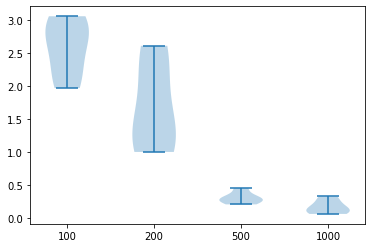

In [26]:
fig, axs = plt.subplots()
axs.violinplot(mse_df)
axs.set_xticks(range(1, len(ns)+1))
axs.set_xticklabels(ns)
plt.show()

Misspecified model 1

In [27]:
ns = [100, 200, 500, 1000]
n_repeat = 5
def my_estimator(X,y):
    model = KernelRidge(kernel="precomputed")
    gscv = GridSearchCV(estimator=model, param_grid=param_grid_kr, scoring='neg_mean_squared_error', n_jobs=8, verbose=0)
    K = kmat_rbf(X,X,g=0.01)
    intercept = np.mean(y)
    gscv.fit(K, y-intercept)
    def pred_fun(K): return gscv.predict(K) + intercept
    return pred_fun, gscv.best_params_, wrap(kmat_rbf, g=0.01), 'kmat_rbf_g_0.01'
mse_df = run_consistency(ns, lambda n: gen_data(n, true_fun), my_estimator, n_repeat)

-- ii = 0 (n = 100) --
best hyperparams {'alpha': 0.000125} with kmat_rbf_g_0.01
best hyperparams {'alpha': 0.000125} with kmat_rbf_g_0.01
best hyperparams {'alpha': 0.000125} with kmat_rbf_g_0.01
best hyperparams {'alpha': 0.0025} with kmat_rbf_g_0.01
best hyperparams {'alpha': 0.000125} with kmat_rbf_g_0.01
-- ii = 1 (n = 200) --
best hyperparams {'alpha': 0.000125} with kmat_rbf_g_0.01
best hyperparams {'alpha': 0.000125} with kmat_rbf_g_0.01
best hyperparams {'alpha': 0.000125} with kmat_rbf_g_0.01
best hyperparams {'alpha': 0.000125} with kmat_rbf_g_0.01
best hyperparams {'alpha': 0.000125} with kmat_rbf_g_0.01
-- ii = 2 (n = 500) --
best hyperparams {'alpha': 0.000125} with kmat_rbf_g_0.01
best hyperparams {'alpha': 0.000125} with kmat_rbf_g_0.01
best hyperparams {'alpha': 0.000125} with kmat_rbf_g_0.01
best hyperparams {'alpha': 0.000125} with kmat_rbf_g_0.01
best hyperparams {'alpha': 0.000125} with kmat_rbf_g_0.01
-- ii = 3 (n = 1000) --
best hyperparams {'alpha': 0.000125} wi

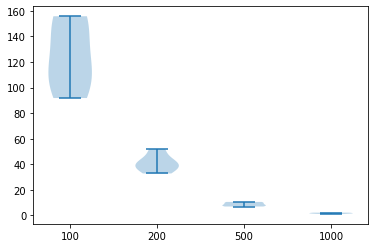

In [28]:
fig, axs = plt.subplots()
axs.violinplot(mse_df)
axs.set_xticks(range(1, len(ns)+1))
axs.set_xticklabels(ns)
plt.show()

Misspecified model 2

In [31]:
ns = [100, 200, 500, 1000]
n_repeat = 5
def my_estimator(X,y):
    model = KernelRidge(kernel="precomputed")
    gscv = GridSearchCV(estimator=model, param_grid=param_grid_kr, scoring='neg_mean_squared_error', n_jobs=8, verbose=0)
    K = kmat_chisq(X,X)
    intercept = np.mean(y)
    gscv.fit(K, y-intercept)
    def pred_fun(K): return gscv.predict(K) + intercept
    return pred_fun, gscv.best_params_, kmat_chisq, 'kmat_chisq'
mse_df = run_consistency(ns, lambda n: gen_data(n, true_fun), my_estimator, n_repeat)

-- ii = 0 (n = 100) --
best hyperparams {'alpha': 0.05} with kmat_chisq
best hyperparams {'alpha': 0.05} with kmat_chisq
best hyperparams {'alpha': 0.05} with kmat_chisq
best hyperparams {'alpha': 0.05} with kmat_chisq
best hyperparams {'alpha': 0.05} with kmat_chisq
-- ii = 1 (n = 200) --
best hyperparams {'alpha': 0.000125} with kmat_chisq
best hyperparams {'alpha': 0.0025} with kmat_chisq
best hyperparams {'alpha': 0.0025} with kmat_chisq
best hyperparams {'alpha': 0.0025} with kmat_chisq
best hyperparams {'alpha': 0.0025} with kmat_chisq
-- ii = 2 (n = 500) --
best hyperparams {'alpha': 0.000125} with kmat_chisq
best hyperparams {'alpha': 0.000125} with kmat_chisq
best hyperparams {'alpha': 0.000125} with kmat_chisq
best hyperparams {'alpha': 0.000125} with kmat_chisq
best hyperparams {'alpha': 0.000125} with kmat_chisq
-- ii = 3 (n = 1000) --
best hyperparams {'alpha': 0.000125} with kmat_chisq
best hyperparams {'alpha': 0.000125} with kmat_chisq
best hyperparams {'alpha': 0.00012

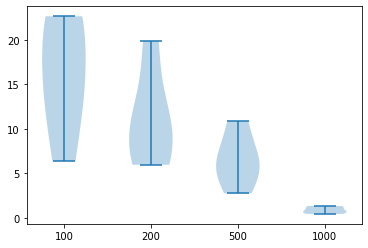

In [32]:
fig, axs = plt.subplots()
axs.violinplot(mse_df)
axs.set_xticks(range(1, len(ns)+1))
axs.set_xticklabels(ns)
plt.show()

The KernelBiome estimator

In [21]:
def my_kb_estimator(X, y):
    n_fold_outer = 10
    n_fold_inner = 5
    scoring = 'neg_mean_squared_error'
    kernel_estimator='kr'
    center_kmat = True
    n_jobs = 6
    kernel_params_dict = default_kernel_params_grid()
    kmat_with_params = get_kmat_with_params(kernel_params_dict)
    train_scores_all, test_scores_all, selected_params_all = run_experiments(X, y, kmat_with_params, param_grid_kr, center_kmat, None, None, 
                                                                             n_fold_outer=n_fold_outer, n_fold_inner=n_fold_inner, 
                                                                             type='regression', scoring=scoring, kernel_estimator=kernel_estimator, 
                                                                             n_jobs=n_jobs, random_state=None, verbose=False)
    best_kernel_models = top_models_in_each_group(kmat_with_params, train_scores_all, test_scores_all, selected_params_all, top_n=1, kernel_mod_only=True)
    model = best_kernel_models.iloc[0]
    pred_fun, gscv = refit_best_model(X, y, 'KernelRidge', param_grid_kr, model, scoring)
    return pred_fun, gscv.best_params_, model.kmat_fun, model.estimator_key

In [22]:
ns = [100, 200, 500, 1000]
n_repeat = 5
mse_df = run_consistency(ns, lambda n: gen_data(n, true_fun), my_kb_estimator, n_repeat)

-- ii = 0 (n = 100) --
best hyperparams {'alpha': 0.0025} with hilbertian_a_1_b_-10
best hyperparams {'alpha': 0.0025} with hilbertian_a_1_b_-10
best hyperparams {'alpha': 0.0025} with hilbertian_a_1_b_-10
best hyperparams {'alpha': 0.000125} with hilbertian_a_10_b_-inf
best hyperparams {'alpha': 0.000125} with generalized-js_a_inf_b_0.5
-- ii = 1 (n = 200) --
best hyperparams {'alpha': 0.05} with hilbertian_a_1_b_-10
best hyperparams {'alpha': 0.05} with hilbertian_a_1_b_-10
best hyperparams {'alpha': 0.05} with hilbertian_a_1_b_-10
best hyperparams {'alpha': 0.0025} with hilbertian_a_1_b_-10
best hyperparams {'alpha': 0.05} with hilbertian_a_1_b_-10
-- ii = 2 (n = 500) --
best hyperparams {'alpha': 0.05} with hilbertian_a_inf_b_-10
best hyperparams {'alpha': 0.05} with hilbertian_a_1_b_-10
best hyperparams {'alpha': 0.05} with hilbertian_a_1_b_-10
best hyperparams {'alpha': 0.05} with hilbertian_a_1_b_-10
best hyperparams {'alpha': 0.05} with hilbertian_a_inf_b_-10
-- ii = 3 (n = 100

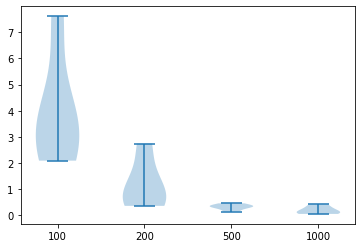

In [23]:
fig, axs = plt.subplots()
axs.violinplot(mse_df)
axs.set_xticks(range(1, len(ns)+1))
axs.set_xticklabels(ns)
plt.show()

### Results collected from server

Process output gathered from sever (dgp6 with kr -- final result)

In [96]:
cfi_mse_df = pd.read_csv("../../src/output_dgp6_kr_v4/kr_pert_cfi_idx_mse_df_seed_0.csv")
for ii in range(1,100):
    try:
        tmp = pd.read_csv(f"../../src/output_dgp6_kr_v4/kr_pert_cfi_idx_mse_df_seed_{ii}.csv")
        cfi_mse_df = pd.concat([cfi_mse_df, tmp])
    except:
        print(f"seed {ii} not found.")
        pass
cfi_mse_df.shape

(100, 4)

In [97]:
cfi_mse_df

,50,100,200,500
0,0.197379,0.104654,0.110904,0.010671
0,0.284599,0.026242,0.095023,0.005636
0,0.115153,0.072444,0.055898,0.007525
0,0.294640,0.048766,0.022071,0.008660
0,0.241276,0.129327,0.082493,0.009816
...,...,...,...,...
0,0.153912,0.191686,0.056058,0.009053
0,0.052766,0.135970,0.065693,0.010492
0,0.175239,0.081433,0.022032,0.120303
0,0.144841,0.083013,0.055058,0.007908


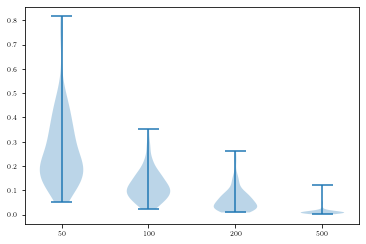

In [98]:
ns = [50, 100, 200, 500]
fig, axs = plt.subplots()
axs.violinplot(cfi_mse_df)
axs.set_xticks(range(1, len(ns)+1))
axs.set_xticklabels(ns)
plt.show()

In [101]:
cpd_mse_df = pd.read_csv("../../src/output_dgp6_kr_v4/kr_cpd_mse_df_seed_0.csv")
for ii in range(1, 100):
    try:
        tmp = pd.read_csv(f"../../src/output_dgp6_kr_v4/kr_cpd_mse_df_seed_{ii}.csv")
        cpd_mse_df = pd.concat([cpd_mse_df, tmp])
    except:
        print(f"seed {ii} not found.")
        pass
cpd_mse_df.shape

(100, 4)

In [102]:
cpd_mse_df

,50,100,200,500
0,3.465466,1.504303,0.399457,0.239741
0,2.093588,2.143393,0.810565,0.300492
0,2.608136,0.894293,0.350104,0.312943
0,0.653279,0.916638,0.994999,0.505922
0,1.758674,0.646007,1.358335,0.774867
...,...,...,...,...
0,1.504000,1.340078,0.152901,0.331695
0,1.136028,1.248937,0.336075,0.408765
0,2.402035,1.297449,0.476145,0.238445
0,5.527133,2.158115,0.596671,0.321968


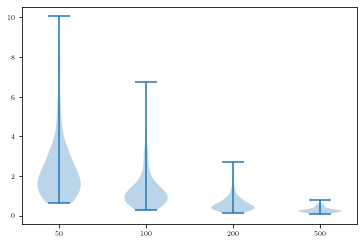

In [103]:
ns = [50, 100, 200, 500]
fig, axs = plt.subplots()
axs.violinplot(cpd_mse_df)
axs.set_xticks(range(1, len(ns)+1))
axs.set_xticklabels(ns)
plt.show()

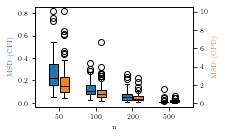

In [104]:
fig, ax1 = plt.subplots()
res1 = ax1.boxplot(
    cfi_mse_df, widths=0.25, positions = np.arange(1, len(ns)+1)-0.15,
    patch_artist=True,
)
for element in ['boxes', 'whiskers', 'fliers', 'means', 'medians', 'caps']:
    plt.setp(res1[element], color='k')

for patch in res1['boxes']:
    patch.set_facecolor('tab:blue')
ax1.set_xlabel('n')
ax1.set_ylabel('MSD (CFI)', color='tab:blue')

ax2 = ax1.twinx()
res2 = ax2.boxplot(
    cpd_mse_df, widths=0.25, positions = np.arange(1, len(ns)+1)+0.15,
    patch_artist=True,
)
for element in ['boxes', 'whiskers', 'fliers', 'means', 'medians', 'caps']:
    plt.setp(res2[element], color='k')

for patch in res2['boxes']:
    patch.set_facecolor('tab:orange')
ax2.set_ylabel('MSD (CPD)', color='tab:orange')

ax1.set_xticks(range(1, len(ns)+1))
ax1.set_xticklabels(ns)
fig.tight_layout()  # otherwise the right y-label is slightly clipped

# plt.style.use("seaborn-white")
fig.set_size_inches(2.6, 1.6)
fig.savefig("../../writeup/consistency_cfi_and_cpd.pdf", bbox_inches='tight')
plt.show()

Process output gathered from sever (dgp6 with svr -- final result)

In [ ]:
cfi_mse_df = pd.read_csv("../../src/output_dgp6/svr_pert_cfi_idx_mse_df_seed_1.csv")
for ii in range(2,101):
    try:
        tmp = pd.read_csv(f"../../src/output_dgp6/kr_pert_cfi_idx_mse_df_seed_{ii}.csv")
        cfi_mse_df = pd.concat([cfi_mse_df, tmp])
    except:
        print(f"seed {ii} not found.")
        pass
cfi_mse_df.shape

In [122]:
cfi_mse_df

,50,100,200,500
0,0.351104,0.396528,0.200864,0.022489
0,0.084381,0.062314,0.077097,0.008503
0,0.321697,0.016595,0.038410,0.008825
0,0.180631,0.095539,0.069322,0.010248
0,0.260435,0.085767,0.031755,0.006538
...,...,...,...,...
0,0.060409,0.092579,0.040232,0.009963
0,0.138264,0.068652,0.018966,0.030232
0,0.146740,0.051120,0.050905,0.008204
0,0.154251,0.226447,0.036400,0.006944


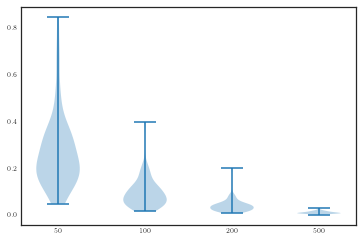

In [123]:
ns = [50, 100, 200, 500]
fig, axs = plt.subplots()
axs.violinplot(cfi_mse_df)
axs.set_xticks(range(1, len(ns)+1))
axs.set_xticklabels(ns)
plt.show()

In [124]:
cpd_mse_df = pd.read_csv("../../src/output_dgp6/svr_cpd_mse_df_seed_1.csv")
for ii in range(2,101):
    tmp = pd.read_csv(f"../../src/output_dgp6/svr_cpd_mse_df_seed_{ii}.csv")
    cpd_mse_df = pd.concat([cpd_mse_df, tmp])
cpd_mse_df.shape

(100, 4)

In [125]:
cpd_mse_df

,50,100,200,500
0,5.383962,15.951572,1.402197,0.789052
0,17.203972,3.822842,6.506650,1.651530
0,1.249981,17.747150,1.509657,1.465680
0,12.662782,11.032861,7.736812,2.862406
0,10.114970,9.845718,0.983315,5.278776
...,...,...,...,...
0,12.112105,3.189643,7.197943,1.564546
0,2.006349,7.598693,8.185749,2.699801
0,13.306669,13.425628,5.184555,1.213752
0,8.264532,5.201596,3.699239,0.926074


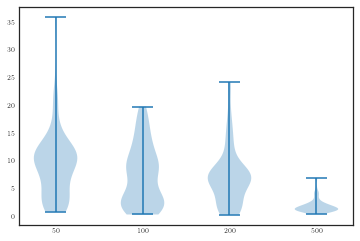

In [126]:
ns = [50, 100, 200, 500]
fig, axs = plt.subplots()
axs.violinplot(cpd_mse_df)
axs.set_xticks(range(1, len(ns)+1))
axs.set_xticklabels(ns)
plt.show()

Process output gathered from server (dgp1 --- final result)

The following were collected from server by running `run_consistency_cpd_dgp1_svr.py` and `run_consistency_pert_cfi_index_dgp1_svr.py` with seed 1 to 100.

In [47]:
cfi_mse_df = pd.read_csv("../../src/output_dgp1_svr/svr_pert_cfi_idx_mse_df_seed_1.csv")
for ii in range(2,101):
    tmp = pd.read_csv(f"../../src/output_dgp1_svr/svr_pert_cfi_idx_mse_df_seed_{ii}.csv")
    cfi_mse_df = pd.concat([cfi_mse_df, tmp])
cfi_mse_df.shape

(100, 4)

In [48]:
cfi_mse_df

,50,100,200,500
0,0.022229,0.007423,0.007610,0.002825
0,0.051661,0.014878,0.004531,0.002084
0,0.016780,0.021636,0.014214,0.003144
0,0.021408,0.019407,0.005315,0.005108
0,0.032334,0.016983,0.020280,0.002855
...,...,...,...,...
0,0.020080,0.063420,0.016907,0.001656
0,0.033858,0.040371,0.004542,0.003864
0,0.018805,0.032177,0.015203,0.003348
0,0.065275,0.016795,0.012111,0.003991


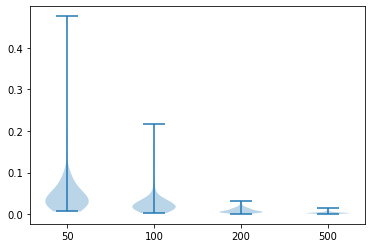

In [49]:
ns = [50, 100, 200, 500]
fig, axs = plt.subplots()
axs.violinplot(cfi_mse_df)
axs.set_xticks(range(1, len(ns)+1))
axs.set_xticklabels(ns)
plt.show()

In [44]:
cpd_mse_df = pd.read_csv("../../src/output_dgp1_svr/svr_cpd_mse_df_seed_1.csv")
for ii in range(2,101):
    tmp = pd.read_csv(f"../../src/output_dgp1_svr/svr_cpd_mse_df_seed_{ii}.csv")
    cpd_mse_df = pd.concat([cpd_mse_df, tmp])
cpd_mse_df.shape

(100, 4)

In [45]:
cpd_mse_df

,50,100,200,500
0,21.015337,2.354786,0.792088,0.047851
0,29.419661,0.139592,0.159583,0.037979
0,2.985153,0.319101,0.037141,0.020981
0,16.528978,0.522933,0.145935,0.022639
0,0.961080,9.251345,0.093914,0.012107
...,...,...,...,...
0,3.463511,1.427156,0.900763,0.019811
0,1.449754,0.571408,3.135972,1.350310
0,17.594305,0.357605,0.288788,0.032076
0,2.823424,0.319659,0.173276,0.008007


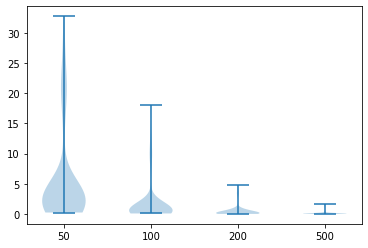

In [46]:
ns = [50, 100, 200, 500]
fig, axs = plt.subplots()
axs.violinplot(cpd_mse_df)
axs.set_xticks(range(1, len(ns)+1))
axs.set_xticklabels(ns)
plt.show()

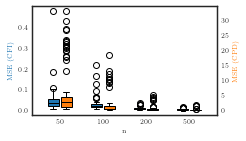

In [73]:
fig, ax1 = plt.subplots()
res1 = ax1.boxplot(
    cfi_mse_df, widths=0.25, positions = np.arange(1, len(ns)+1)-0.15,
    patch_artist=True,
)
for element in ['boxes', 'whiskers', 'fliers', 'means', 'medians', 'caps']:
    plt.setp(res1[element], color='k')

for patch in res1['boxes']:
    patch.set_facecolor('tab:blue')
ax1.set_xlabel('n')
ax1.set_ylabel('MSE (CFI)', color='tab:blue')

ax2 = ax1.twinx()
res2 = ax2.boxplot(
    cpd_mse_df, widths=0.25, positions = np.arange(1, len(ns)+1)+0.15,
    patch_artist=True,
)
for element in ['boxes', 'whiskers', 'fliers', 'means', 'medians', 'caps']:
    plt.setp(res2[element], color='k')

for patch in res2['boxes']:
    patch.set_facecolor('tab:orange')
ax2.set_ylabel('MSE (CPD)', color='tab:orange')

ax1.set_xticks(range(1, len(ns)+1))
ax1.set_xticklabels(ns)
fig.tight_layout()  # otherwise the right y-label is slightly clipped

# plt.style.use("seaborn-white")
fig.set_size_inches(3, 1.7)
fig.savefig("../../writeup/consistency_cfi_and_cpd.pdf", bbox_inches='tight')
plt.show()